#  Прогнозирование заказов такси

Сервис заказа такси собрал исторические данные о заказах такси в аэропортах.   
Компания хочет привлекать больше водителей в период пиковой нагрузки для удовлетворения дополнительного спроса.  

**Задача** 

Срогнозировать количество заказов такси на следующий час.  
Точность прогнозирования проверяется по метрике RMSE и должна быть не выше 48 на тестовой выборке в 10%.

## План работы

1. Загрузить и исследовать данные

2. Проанализировать данные на наличие тренда и сезонности

3. Обучить модели с подбором оптимального набора признаков + подбором гиперпараметров на кросс-валидации:   
    - Линейная регрессия
    - регрессия Elastic Net
    - LightGBM бустинг
    - Prophet 
    - Сделать сводую таблицу результатов кросс-валидации

4. Провести тестирование на 10% данных
    - Сгенерировать "дамми" модель для проверки моделей на адекватность
    - Проверить модели *(i)* на тестовых данных

5. Составить выводы и рекомендации

*(i) В виду специфики проекта отойдём от классического подхода и проверим все модели*

## Описание данных

Данные находятся в файле `taxi.csv`.  
Имеется столбец со временем заказа и кол-во заказов в столбце `num_orders`.

## Подготовка и анализ данных

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd

#Прогресс выполнения и время работы
from time import time
from tqdm import tqdm

#Модели
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from prophet import Prophet
from sklearn.dummy import DummyRegressor

# Метрики, средства анализа, прочее
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

# Визуализация
# Для Git Hub не использую 'тяжелую' графику, например, cufflinks/plotly
import matplotlib.pyplot as plt

### Настройки и константы

In [2]:
RANDOM_STATE = 12345

# Выключим назойливые логи-простыни

from warnings import simplefilter 
simplefilter (action='ignore', category=pd.errors.PerformanceWarning)

import sklearn.exceptions as se 
simplefilter (action='ignore', category=se.FitFailedWarning)
simplefilter (action='ignore', category=se.ConvergenceWarning)

import logging

logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True
logging.getLogger('fbprophet').disabled = True

### Пользовательские функции

#### Генерация признаков из данных о дате и времени

Для ML моделей общего назначения требуются синтетические признаки.   
Можно использовать параметры их генерации для минимизации ошибки предсказания конкретной ML модели.  

Генерируемые признаки

- Неизменяемые 
    - день недели в виде числа
    - час
    - разница значений предыдущий-текущий период
    
- Изменяемые в зависимости от настроек генерации
    - скользящее среднее с варьируемой шириной "окна"
    - скользящее стандартное отклонение с варьируемой шириной "окна"
    - отстающие значения ("лаги"), варьируемое количество

*Месяц использовать некорректно, т.к. не достаточно данных (нужны данные хотя бы за 12 мес.)*

In [3]:
def func_make_features(data, max_lag, rolling_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Изменяемые и расчётные признаки

    #Текущее значение ряда для расчёта скользящего среднего, ст. отклонения и разницы значенений, применять нельзя.
    #Это утечка целевого признака. Shift убирает текущее значение.

    # Разница значений прошлых периодов
    data['diff'] = data['num_orders'].shift().fillna(0) - data['num_orders'].shift(2).fillna(0)

    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean().fillna(0)

    # Cтандартное отклонение
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_size).std().fillna(0)

    # Лаги
    # Пустоты заполним нулями
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag).fillna(0)

    # Первые 2 строки не информативны, т.к. состоят почти полностью из нулей
    data.drop(index=data.index[0:1], inplace=True)

#### Подбор оптимального числа лагов и ширины скользящего окна   
- возращает оптимизированный под конкретную ML модель датасет
- для ускорения работы прекращает перебор по "множителю отсечки" если нет улучшения уже достигнутой метрики
- строит графики подбора
- можно задавать "множитель отсечки" и лимит для перебора

*Подбирает число лагов, а потом к нему ширину окна. Такой подход оказался более быстрым по сравнению с вложенными циклами при такой же точности.*

In [4]:
def func_pick_lags_rolls(model:object, df_data:object, show_plot=False, max_pick=1000, pick_break_limiter=1.12):

    # Инициируем начальные значения
    best_rmse = 100
    best_lags = 1
    best_roll = 1
    # тут логи и RMSE для графика
    log_lags = [[], []] 
    log_rolls = [[], []]

    # ПОДБИРАЕМ ОПТИМАЛЬНОЕ ЧИСЛО ЛАГОВ, ЗАТЕМ К НЕМ ОПТИМАЛЬНОЕ ОКНО СКОЛЬЗЯЩИХ ЗНАЧЕНИЙ
    # Перебираем лаги по 6 часов
    for lag in tqdm(range(6, max_pick, 6)):
        data = df_data.copy()
        func_make_features(data, max_lag=lag, rolling_size=12)   
        train, valid = train_test_split(data, test_size=0.2, shuffle=False)

        x_train = train.drop(columns='num_orders')
        y_train = train['num_orders']
        x_valid = valid.drop(columns='num_orders')
        y_valid = valid['num_orders']

        model.fit(x_train, y_train)
        preds = model.predict(x_valid)
        rmse = mean_squared_error(preds, y_valid)**0.5
        log_lags[0].append(lag)
        log_lags[1].append(rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lags = lag
        if rmse > best_rmse * pick_break_limiter:
            break  

    # Перебираем ширину окон по 12 часов
    # Инициируем начальные значения
    best_rmse = 100   
    for roll_size in tqdm(range(6, 73, 6)):
        data = df_data.copy()
        func_make_features(data, max_lag=best_lags, rolling_size=roll_size)   
        train, valid = train_test_split(data, test_size=0.2, shuffle=False)

        x_train = train.drop(columns='num_orders')
        y_train = train['num_orders']
        x_valid = valid.drop(columns='num_orders')
        y_valid = valid['num_orders']

        model.fit(x_train, y_train)
        preds = model.predict(x_valid)
        rmse = mean_squared_error(preds, y_valid)**0.5
        log_rolls[0].append(roll_size)
        log_rolls[1].append(rmse)
        if rmse < best_rmse:
            best_rmse = rmse
            best_roll = roll_size
    
    # ЗАПИШЕМ ИТОГОВЫЕ ПОКАЗАТЕЛИ
    print()
    print('------------------------------------')
    print('Наилучшая метрика', best_rmse.__round__(3))
    print('Оптимальное число лагов в признаках', best_lags)
    print('Оптимальная ширина окна', best_roll)

    # СТРОИМ ГРАФИКИ
    if show_plot:       
        pd.DataFrame({'Число лагов':log_lags[0], 'Метрика RMSE':log_lags[1]}).plot(
                       title='Зависимость метрики от числа лагов', 
                       y='Метрика RMSE', x='Число лагов', 
                       xlabel='число лагов', ylabel='RMSE', 
                       legend=False, figsize=(10,3))
        
        pd.DataFrame({'Окно':log_rolls[0], 'Метрика RMSE':log_rolls[1]}).plot(
                       title='Зависимость метрики от ширины окон среднего значения и ст. отклонения', 
                       y='Метрика RMSE', x='Окно', 
                       xlabel='ширина окна', ylabel='RMSE', 
                       legend=False, figsize=(10,3));    

    return best_lags, best_roll

### Загрузка и знакомство с данными

In [5]:
# Загрузка данных

try:
    df = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
# Проверка загрузки и парсинга дат в индекс 

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Задача прогнозировать кол-во заказов в час, по этому сделаем ресемплинг по одному часу.  

In [8]:
df = df.resample('1h').sum()
df_1h_raw = df.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Выводы первичного анализа данных**
- данные за 6 полных месяцев с марта по август 2018 включительно; признак месяца использовать не целесообразно.
- пропусков нет
- данные даны с интервалом 10 мин, проведён ресемплинг по часу
- данных немного - 4.4 тыс. строк после ресемплинга

### Анализ

Отсортируем данные по времени и верхнеуровнево посмотрим

In [10]:
df.sort_index(ascending=True, inplace=True)

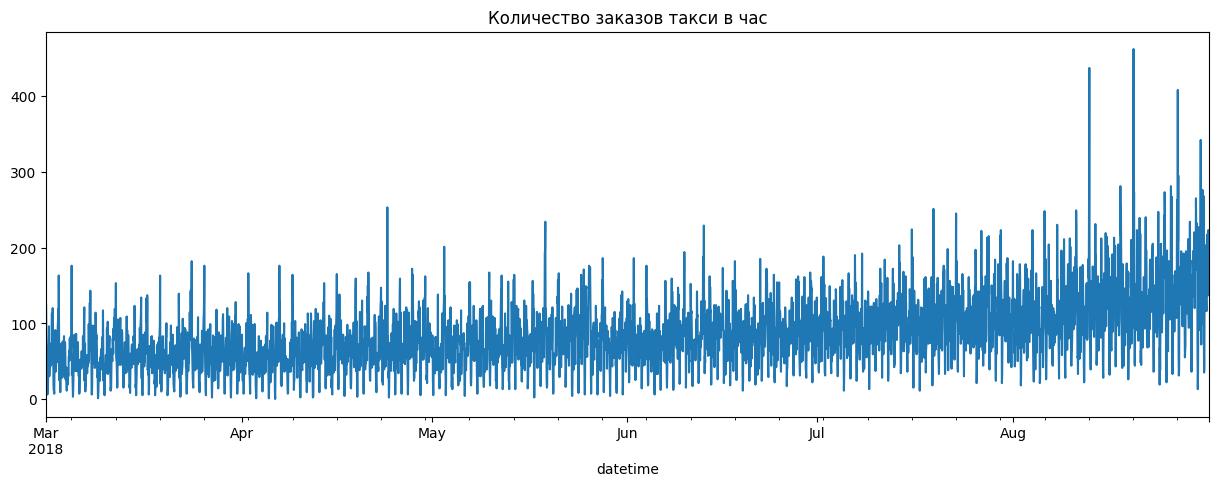

In [11]:
df.plot(figsize=(15,5), legend=False, title='Количество заказов такси в час');

График с ресемплированием в час не очень хорошо читается, сделаем аналогичный по дням.

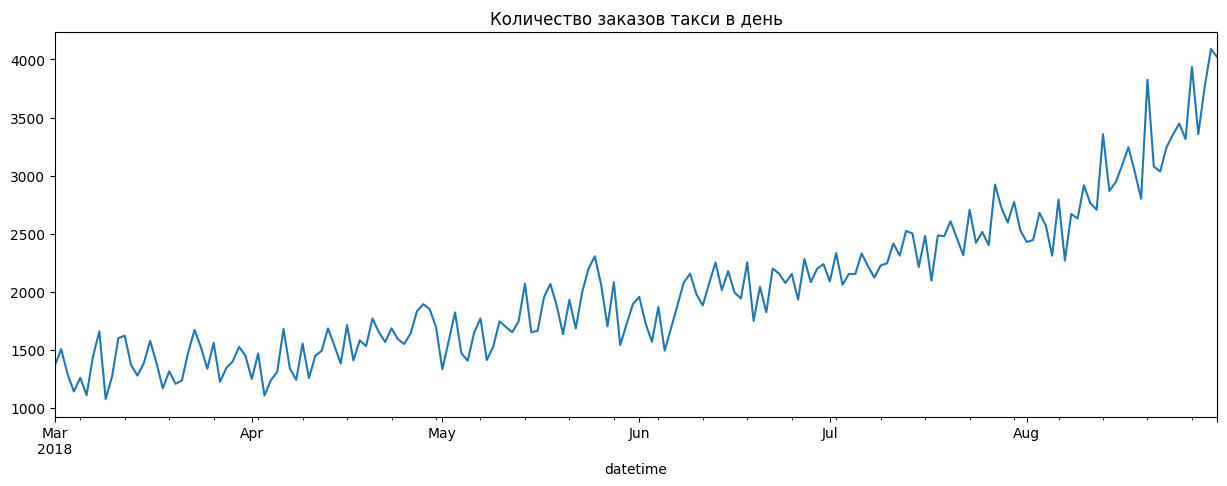

In [12]:
df.resample('1d').sum().plot(figsize=(15,5), legend=False, title='Количество заказов такси в день');

Видно, что дела у компании идут в гору.  
- Есть явный восходящий тренд, ускоряющийся в июне.  
- Из данных по заказам в час и в день видно, что есть пиковые значения в разы превышаюшие средние.

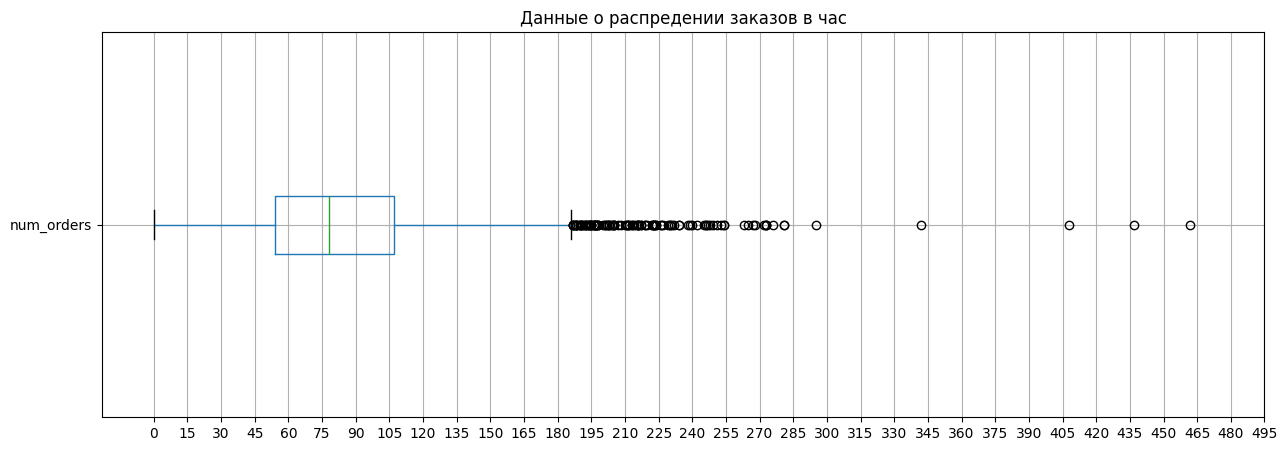

In [13]:
df.boxplot(vert=False, figsize=(15,5));
plt.title('Данные о распредении заказов в час')
plt.xticks(range(0,500,15));

- Медианное значение количества заказов в час 75
- Типичное количество заказов в час находится в диапазоне от 0 до 180  
- Есть пиковые значения (выбросы) от 185 до 465 

Рассмотрим тренд и сезонность в данных

In [14]:
decompose = seasonal_decompose(df)
trend = decompose.trend
seasonal = decompose.seasonal
residue = decompose.resid

#### Тренд

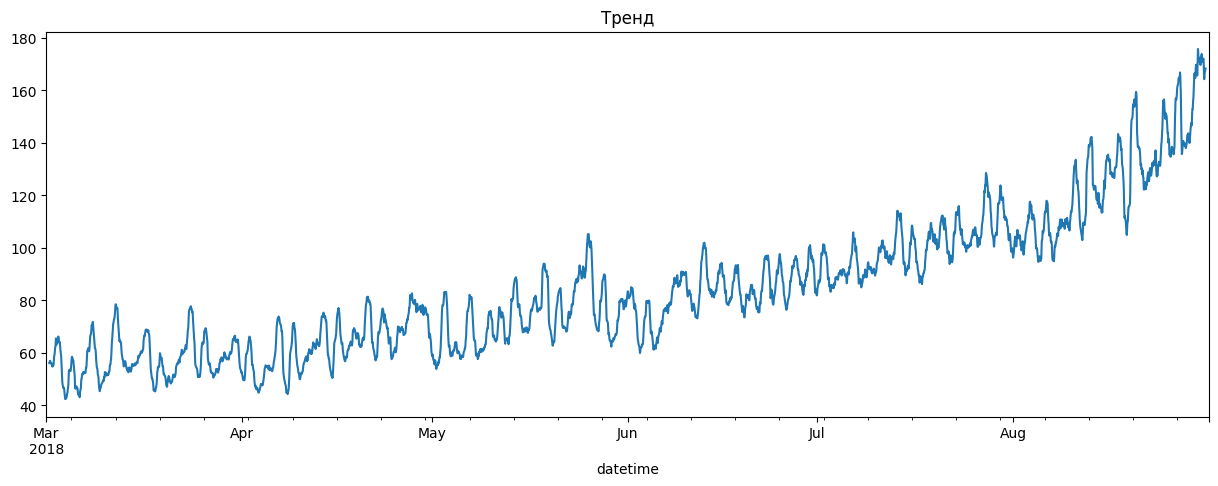

In [15]:
trend.plot(figsize=(15,5), title='Тренд');

Подтверждается, что имеется тренд на увеличение заказов в час, ускоряющийся начиная с июня. 

#### Часовая сезонность
Ниже 3 графика с интервалами по 2 дня в начале, середине и конце датасета, чтобы был виден каждый час.  
Благодаря этому можно посмотреть сезонность по часам.

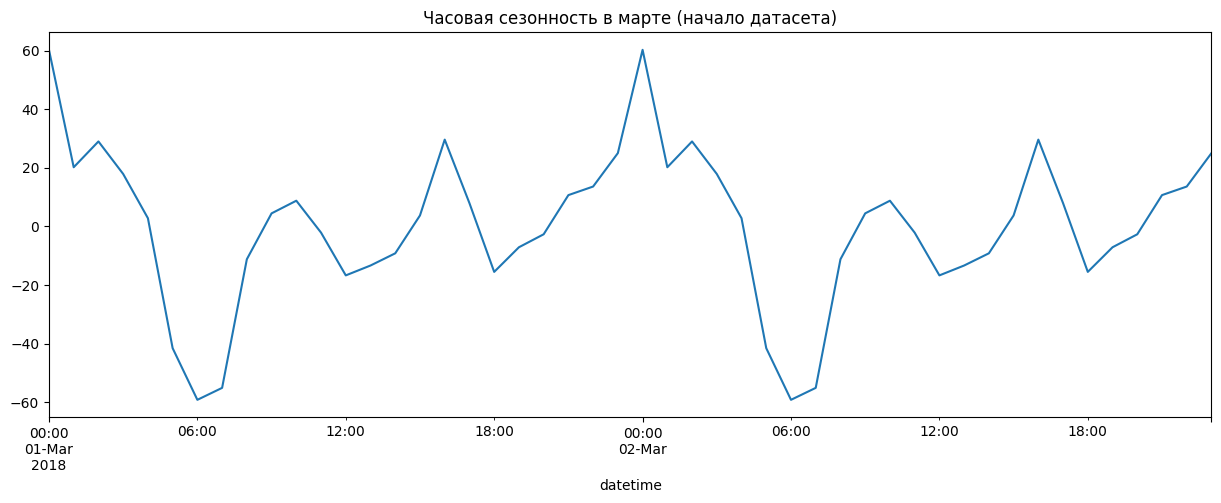

In [16]:
seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15,5), title='Часовая сезонность в марте (начало датасета)');

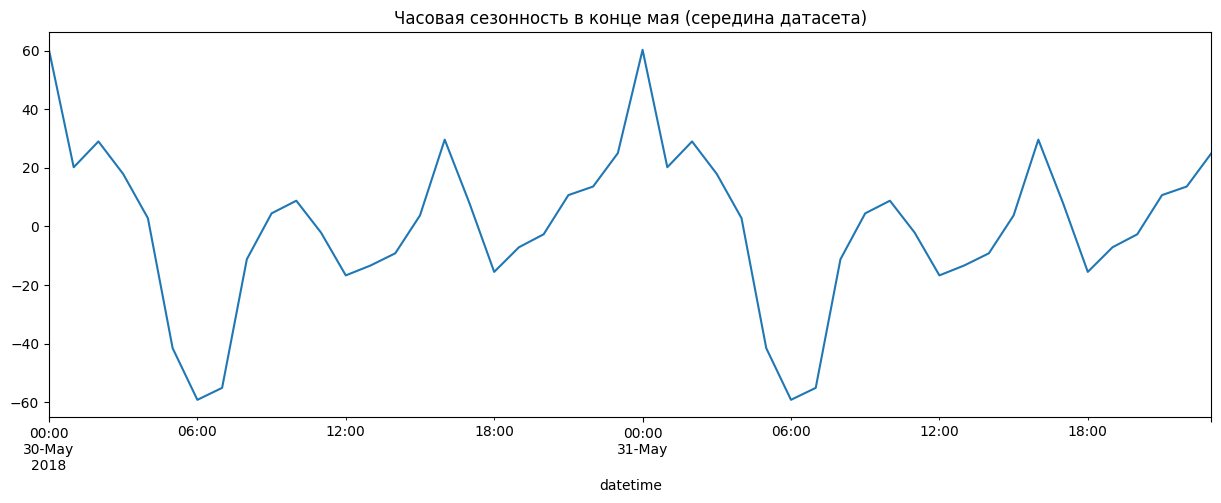

In [17]:
seasonal['2018-05-30':'2018-05-31'].plot(figsize=(15,5), title='Часовая сезонность в конце мая (середина датасета)');

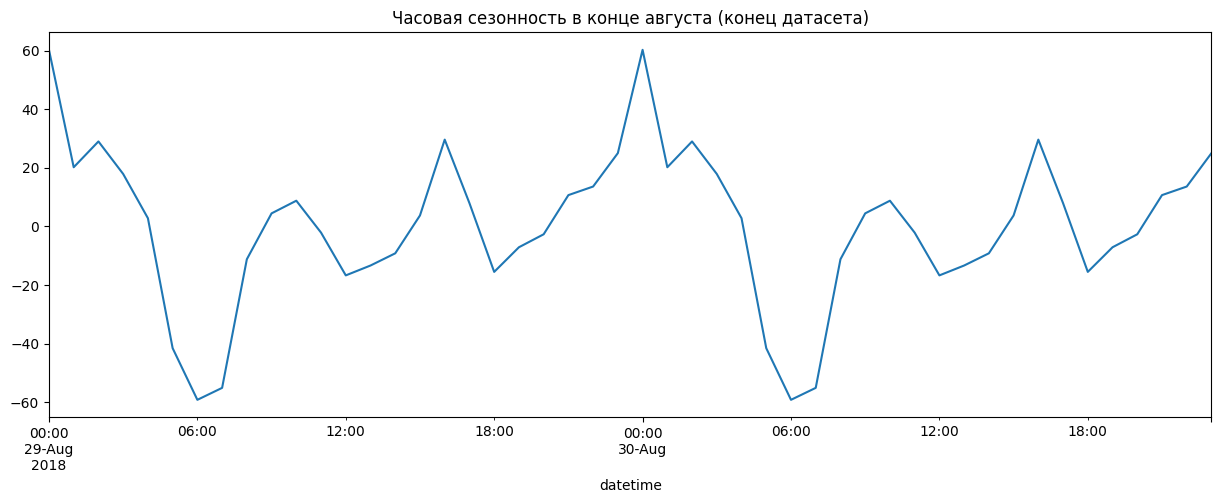

In [18]:
seasonal['2018-08-29':'2018-08-30'].plot(figsize=(15,5), title='Часовая сезонность в конце августа (конец датасета)');

- Есть устойчивая сезонность в зависимости от часа стабильная независимо от месяца:
    - пики в полночь и ок. 13 и 17 часов, а так же в полночь 
    - спад ок. 6 часов утра.

#### Недельная сезонность

Посмотрим есть ли зависимость числа заказов от дня недели

In [19]:
df_week_day = df.resample('1D').sum().reset_index()
df_week_day['day_of_week'] = df_week_day['datetime'].dt.dayofweek
df_week_day.set_index('datetime', inplace=True)

In [20]:
by_day_of_week = df_week_day.groupby(by='day_of_week').agg('sum')

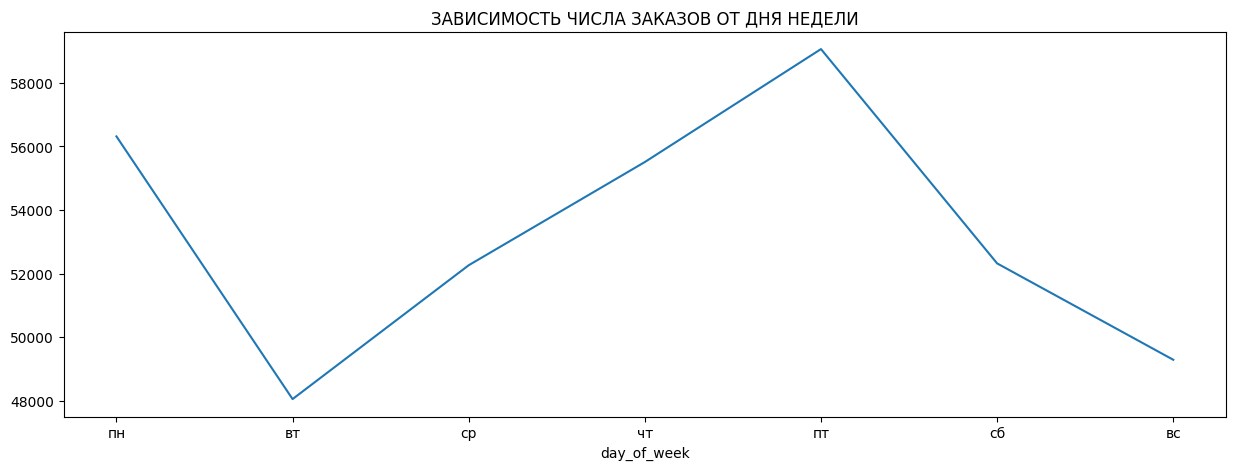

In [21]:
by_day_of_week.plot(figsize=(15,5), legend=False, title='ЗАВИСИМОСТЬ ЧИСЛА ЗАКАЗОВ ОТ ДНЯ НЕДЕЛИ');
plt.xticks(labels=['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'], ticks=range(0,7));

#### Выводы анализа
- Есть пиковые значения числа заказов, до 6 раз превышающие медианное значение (75)
- Типичное количество заказов в час находится в диапазоне от 0 до 180  
- Данные нестационарные, т.к.:
    - Есть устойчивая внутрисуточная сезонность независимо от месяца:
        - пики в полночь и ок. 13 и 17 часов, а так же в полночь 
        - спад ок. 6 часов утра.
    - Наблюдается умеренный восходящий тренд до июня, затем рост ускоряется в середине периода
- Из-за ускорения темпов роста в июле среднее число заказов так же будет увеличиваться
- В разные дни недели число заказов существенно различается:
    - понедельник и пятница наиболее загруженные дни
    - вторник и воскресенье наименее

## Моделирование

### О создании признаков для моделирования

- Условия генерации признаков можно связать с минимизацией ошибки предсказания конкретной ML модели.  
- Реализуем генерацию признаков c помощью приведённых выше пользовательских функций.  
Такое решение обеспечит гибкость на инференсе, т.к. позволит при каждом обучении модели автоматически подстваиваться под возможные изменения в тренде и сезонности.

- Для модели Prophet требуется отдельная предобработка данных.

### Разбиение на обучающую и тестовую выборки

Важно, чтобы тестовые данные строго были за период после обучающих. Иначе произойдёт утечка целевого признака.  
Для разбивки используем классический метод, но без перемешивания.

Разбивку сделаем на 3 выборки: 
- обучающую
- валидационную (для подбора параметров генерации признаков) 
- тестовую в 10% данных для итогового тестирования согласно требований заказчика

In [22]:
# Убедимся, что данные отсортированы по времени
df.sort_index(ascending=True, inplace=True)

# Разобьем данные без перемешивания, чтобы сохранить направленность временного ряда
df_train_valid, df_test = train_test_split(df, test_size=0.1, shuffle=False)

### Линейная регрессия

##### Подбор числа лагов и ширины окон для скользащего среднего и ст. отклонения

100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


------------------------------------
Наилучшая метрика 27.038
Оптимальное число лагов в признаках 336
Оптимальная ширина окна 12


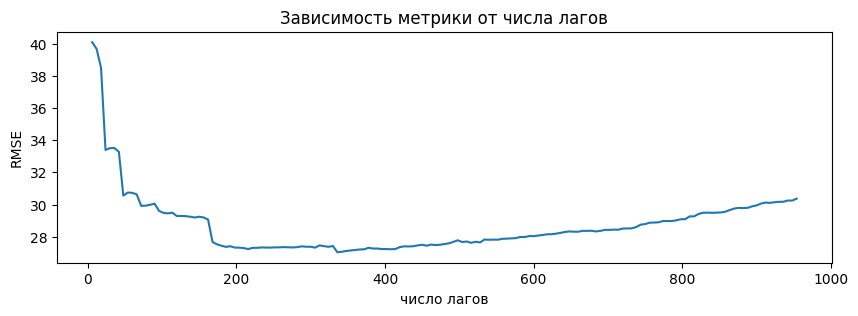

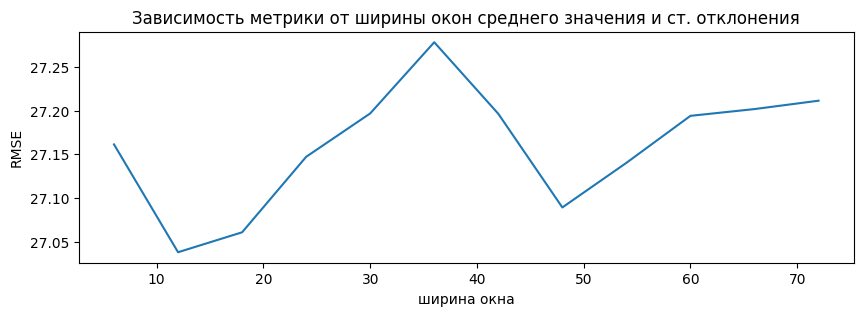

In [23]:
best_LR_lag, best_LR_roll = func_pick_lags_rolls(LinearRegression(), df_data=df_train_valid, show_plot=True)

##### Подбор гиперпараметров модели при оптимальных показателях генерации признаков
Оптимизируем метрику через подбор гиперпараметров на кросс-валидации:
- считать ли свободный коэффициент регрессии (интерсепт) (`fit_intercept`)

In [24]:
# После изысканий выше знаем оптимальное число лагов и величины окон.
# Сгенерируем финальный датасет для подбора гиперпараметров и замера времени обучения.

data_LR = df_train_valid.copy()
func_make_features(data_LR, max_lag=best_LR_lag, rolling_size=best_LR_roll)
x_LR = data_LR.drop(columns='num_orders')
y_LR = data_LR['num_orders']

In [25]:
model = LinearRegression()
params = {'fit_intercept':[True, False]} # default True

grid_LR = GridSearchCV(estimator=model,
                            param_grid=params,
                            cv=TimeSeriesSplit(n_splits=3).split(x_LR, y_LR),
                            scoring='neg_mean_squared_error') 

grid_LR.fit(x_LR, y_LR)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000287A1410CA0>,
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [26]:
print('Оптимальные гиперпараметры модели', grid_LR.best_params_)
print('Наилучшая метрика на кросс-валидации:', round((grid_LR.best_score_ * -1) ** 0.5, 3))

# Сохраним итоговый результат для сводной таблицы 
best_LR_rmse = (grid_LR.best_score_ * -1) ** 0.5

Оптимальные гиперпараметры модели {'fit_intercept': False}
Наилучшая метрика на кросс-валидации: 24.641


##### Время обучения
Обучим модель с подобранными гипераметрами на обучающей и валидационной выборках.  
Засечём время обучения. 

In [27]:
LR_model_best = LinearRegression(**grid_LR.best_params_)
data = df_train_valid.copy()
func_make_features(data, max_lag=best_LR_lag, rolling_size=best_LR_roll)
x = data.drop(columns='num_orders')
y = data['num_orders']

start = time()
LR_model_best.fit(x, y)
end = time()

LR_time = round((end - start), 2)

print('Время обучения модели', LR_time)

Время обучения модели 0.1


### Регрессия ElasticNet

Данная модель - вариант линейной регрессии с гибридной l1/l2 регуляризацией.  


##### Подбор числа лагов и ширины окон для скользащего среднего и ст. отклонения

100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


------------------------------------
Наилучшая метрика 26.99
Оптимальное число лагов в признаках 336
Оптимальная ширина окна 48


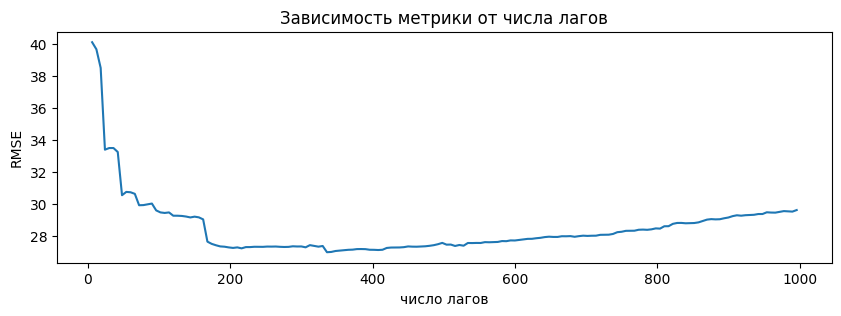

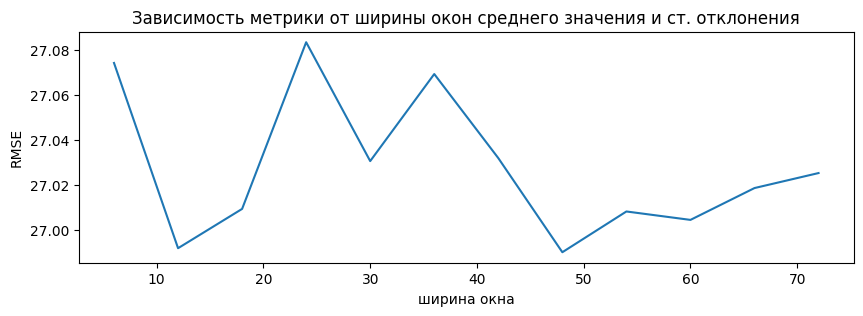

In [28]:
best_Elastic_lag, best_Elastic_roll = func_pick_lags_rolls(ElasticNet(random_state=RANDOM_STATE), df_data=df_train_valid, show_plot=True)

#### Подбор гиперпараметров
Оптимизируем метрику через подбор гиперпараметров на кросс-валидации:
- соотношение l1/l2 регуляризации (`l1_ratio`)
- считать ли свободный коэффициент регрессии (интерсепт) (`fit_intercept`)
- ставить ли принудительно только положительные веса (`positive`)

In [29]:
# После изысканий выше знаем оптимальное число лагов и величины окон для регрессии
# Сделаем из них датасет для подбора гиперпараметров и замера временени обучения

data = df_train_valid.copy()
func_make_features(data, max_lag=best_Elastic_lag, rolling_size=best_Elastic_roll)
x = data.drop(columns='num_orders')
y = data['num_orders']

In [30]:
model = ElasticNet(random_state=RANDOM_STATE)
params = {'l1_ratio':np.arange(0, 1.1, 0.1),  # default 0.5
          'fit_intercept':[True, False],      # default True
          'positive':[True, False],           # default False
          'max_iter':[1000, 2000]             # default 1000
          } 

grid_Elastic = GridSearchCV(estimator=model,
                            param_grid=params,
                            cv=TimeSeriesSplit(n_splits=3).split(x),
                            scoring='neg_mean_squared_error')

grid_Elastic.fit(x, y)


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000287A1410F60>,
             estimator=ElasticNet(random_state=12345),
             param_grid={'fit_intercept': [True, False],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [1000, 2000], 'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [31]:
print('Оптимальные гиперпараметры модели', grid_Elastic.best_params_)
print('Наилучшая метрика:', round((grid_Elastic.best_score_ * -1) ** 0.5, 3))

# Сохраним итоговый результат для сводной таблицы 
best_Elastic_rmse = (grid_Elastic.best_score_ * -1) ** 0.5

Оптимальные гиперпараметры модели {'fit_intercept': False, 'l1_ratio': 1.0, 'max_iter': 1000, 'positive': True}
Наилучшая метрика: 23.188


##### Время обучения
Обучим модель с подобранными гипераметрами на обучающей и валидационной выборках.  
Засечём время обучения. 

In [32]:
Elastic_model_best = ElasticNet(random_state=RANDOM_STATE, **grid_Elastic.best_params_)

start = time()
Elastic_model_best.fit(x, y)
end = time()

Elastic_time = round((end - start), 2)

print('Время обучения модели', Elastic_time)

Время обучения модели 0.1


### LightGBM

##### Подбор числа лагов и ширины окон для скользащего среднего и ст. отклонения

  0%|          | 0/166 [00:00<?, ?it/s]e:\UpdatedProject Venv on Python 3.12.2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\UpdatedProject Venv on Python 3.12.2\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


------------------------------------
Наилучшая метрика 27.947
Оптимальное число лагов в признаках 474
Оптимальная ширина окна 12


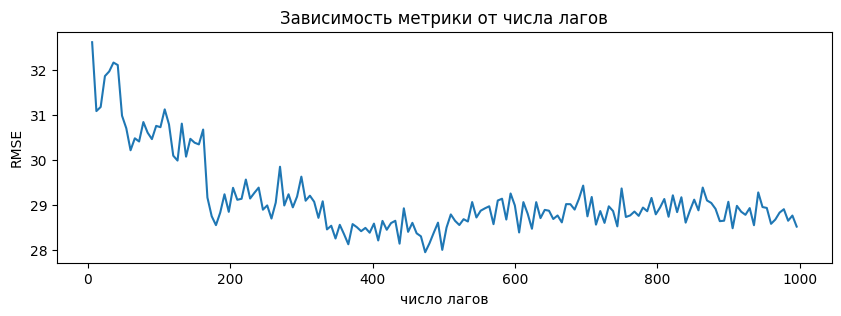

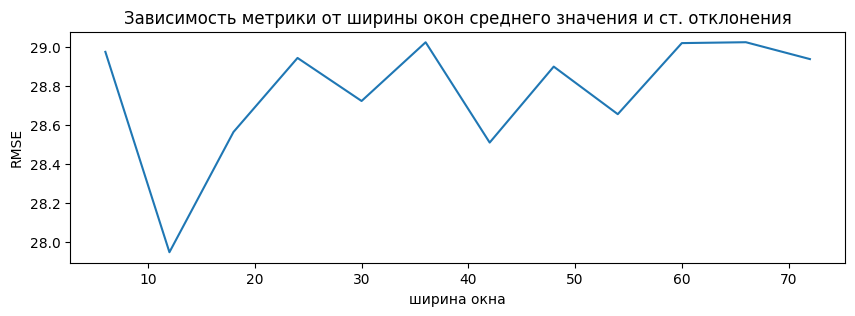

In [33]:
best_LGBM_lag, best_LGBM_roll = func_pick_lags_rolls(LGBMRegressor(random_state=RANDOM_STATE, device='GPU', verbose=-1), df_data=df_train_valid, show_plot=True)

##### Подбор гиперпараметров модели при оптимальных показателях генерации признаков
- ключевой кол-во деревьев (`n_estimators`)
- l1 и l2 регуляризацию (`reg_alpha`, `reg_lambda`)

In [34]:
# После изысканий выше знаем оптимальное число лагов и величины окон.
# Сделаем из них датасет для подбора гиперпараметров и замера временени обучения

data = df_train_valid.copy()
func_make_features(data, max_lag=best_LGBM_lag, rolling_size=best_LGBM_roll)

x = data.drop(columns='num_orders')
y = data['num_orders']

In [35]:
model = LGBMRegressor(random_state=RANDOM_STATE, device='GPU', verbose=-1)
params = {'n_estimators':[100, 200],             # default 100
          'reg_alpha':[0., 0.3, 0.6, 0.9, 1.0],  # default 0. L1 regularization term on weights
          'reg_lambda':[0., 0.3, 0.6, 0.9, 1.0]  # default 0. L2 regularization term on weights
          }

grid_LGBM = GridSearchCV(estimator=model,
                            param_grid=params,
                            cv=TimeSeriesSplit(n_splits=3).split(x),
                            scoring='neg_mean_squared_error')

grid_LGBM.fit(x, y)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002879EF897A0>,
             estimator=LGBMRegressor(device='GPU', random_state=12345,
                                     verbose=-1),
             param_grid={'n_estimators': [100, 200],
                         'reg_alpha': [0.0, 0.3, 0.6, 0.9, 1.0],
                         'reg_lambda': [0.0, 0.3, 0.6, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [36]:
print('Оптимальные гиперпараметры модели', grid_LGBM.best_params_)
print('Наилучшая метрика:', round((grid_LGBM.best_score_ * -1) ** 0.5, 3))

# Сохраним итоговый результат для сводной таблицы 
best_LGBM_rmse = (grid_LGBM.best_score_ * -1) ** 0.5

Оптимальные гиперпараметры модели {'n_estimators': 200, 'reg_alpha': 1.0, 'reg_lambda': 0.0}
Наилучшая метрика: 23.478


##### Время обучения
Обучим модель с подобранными гипераметрами на обучающей и валидационной выборках.  
Засечём время обучения. 

In [37]:
LGBM_model_best = LGBMRegressor(random_state=RANDOM_STATE, **grid_LGBM.best_params_, verbose=-1) 

start = time()
LGBM_model_best.fit(x, y)
end = time()

LGBM_time = round((end - start), 2)

print('_______________')
print('Время обучения модели', LGBM_time)

_______________
Время обучения модели 1.4


### Prophet
Специализированная модель для прогнозирования временных рядов.  
Попробуем её "из коробки" и с перебором гиперпараметров на кросс-валидации.

#### Подготовка дата-сета

In [38]:
data_prophet = df_train_valid.copy()

# Убираем 20% на валидацию и задаём горизонт прогнозирования
predictions = len(df_train_valid) * 0.2

# приводим dataframe к нужному формату
data_prophet  = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']

# разбиваем на обучающую и валидационную выборки

prophet_train, prophet_valid = train_test_split(data_prophet, test_size=0.2, shuffle=False)

#### Прогнозирование "из коробки"

In [39]:
prophet_model = Prophet()
prophet_model.fit(prophet_train);

In [40]:
# Зададим интервал прогнозирования
future = prophet_model.make_future_dataframe(periods=len(prophet_valid), freq='h')

forecast = prophet_model.predict(future)

print('Некоторые признаки, генерируемые моделью Prophet \n')
forecast[['ds', 'yhat', 'yhat_lower',
		'yhat_upper', 'trend',
		'trend_lower', 'trend_upper']].tail()

Некоторые признаки, генерируемые моделью Prophet 



,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
3969,2018-08-13 09:00:00,118.034284,87.854874,144.342511,106.598163,105.762930,107.414307
3970,2018-08-13 10:00:00,122.893532,95.103614,154.618243,106.614024,105.776763,107.431652
3971,2018-08-13 11:00:00,111.924414,83.925932,139.892372,106.629885,105.790929,107.448996
3972,2018-08-13 12:00:00,98.392101,69.482884,127.249463,106.645746,105.804812,107.466340
3973,2018-08-13 13:00:00,96.044529,65.952070,124.758978,106.661607,105.818695,107.483685


Модель выдаём данные факт + прогноз в одном датасете и множество данных, в т.ч. интервалы по прогнозу и тренду.  
Нам для вычисления метрики нужен только пронгоз (признак 'yhat').

In [41]:
# Модель делает единый датасет факт + прогноз. Возьмём только прогноз.
preds = forecast[['ds', 'yhat']]
preds = preds.set_index('ds').tail(len(prophet_valid))

In [42]:
rmse = mean_squared_error(preds['yhat'], prophet_valid['y'])**0.5
print('Наилучшая метрика "из коробки":', round(rmse, 3))

Наилучшая метрика "из коробки": 32.203


Результат не блестящий для модели специально разработанной для задач временных рядов.  
Может быть настройка гиперпараметров поможет, модель Prophet аддитивной регрессией; обычно регрессии чутко реагируют на гиперпараметры.

#### Подбор гиперпараметров на кросс-валидации

У модели свой встроенный метод кросс-валидации, используем его.
Оптимизируем метрику через подбор гиперпараметров на кросс-валидации:
- l1/l2 регуляризация точек изменения (`changepoint_prior_scale`)
- подход к оценке сезонности (`seasonality_mode`)
- l1/l2 регуляризация сезонности (`changepoint_prior_scale`)
- т.к. в данных есть и недельная и внутрисуточная сезонность явно их отметим (`weekly_seasonality` и `daily_seasonality`)

In [43]:
param_grid = {'changepoint_prior_scale':[0.001, 0.05, 0.08, 0.5],  # default 0.05 нет регуляризации (L1-L2 регуляризация)
              'seasonality_mode':['additive', 'multiplicative'],   # default 'additive'  
              'seasonality_prior_scale':[0.01, 1, 5, 10, 12],      # default 10 нет регуляризации (L1-L2 регуляризация)
              'weekly_seasonality':[True],                         # default auto, в данных явно есть недельная сезонность
              'daily_seasonality':[True]                           # default auto, в данных явно есть суточная сезонность          
             }

# Комбинации возможных параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

#Список для хранения метрики для каждой комбинации
rmses =[]

for params in all_params:
    model = Prophet(**params).fit(data_prophet)
    df_cv = cross_validation(model, horizon='96 hours', parallel='processes') # на параметр horizon завязано число фолдов
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Лучшая метрика и оптимизированные гиперпараметры
best_Prophet_score = tuning_results['rmse'].min()
best_Prophet_params = all_params[np.argmin(rmses)]

print('Оптимальные гиперпараметры модели', best_Prophet_params)
print('Наилучшая метрика:', round(best_Prophet_score, 3))

Оптимальные гиперпараметры модели {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': True, 'daily_seasonality': True}
Наилучшая метрика: 25.187


##### Время обучения
Обучим модель с подобранными гипераметрами на обучающей и валидационной выборках.  
Засечём время обучения. 

In [44]:
Prophet_model_best = Prophet(**best_Prophet_params)

start = time()
Prophet_model_best.fit(data_prophet)
end = time()

Prophet_time = round((end - start), 2)

print('_______________')
print('Время обучения модели', Prophet_time)

_______________
Время обучения модели 0.33


### Сводные данные по итогам кросс-валидации моделей
**Выводы:**  
1) Наилучшие результаты по метрике и скорости обучения показала модель Elastic Net.

2) Близкая метрика у бустинга LightGBM при более длительном(в 10 раз дольше) обучении.

3) Интересно, что специализированная модель Prophet показала результаты чуть хуже, чем универсальные модели + настраиваемая генерация синтетических признаков.

4) Оптимальное кол-во лагов и ширина скользящих окон различаются в зависимости от типа модели  
(даже у "родственных" Линейной регрессии и Elastic Net)   

In [45]:
score_table = [[round(best_LGBM_rmse, 3), LGBM_time, best_LGBM_lag, best_LGBM_roll],
               [round(best_Elastic_rmse, 3), Elastic_time, best_Elastic_lag, best_Elastic_roll],
                [round(best_LR_rmse, 3), LR_time, best_LR_lag, best_LR_roll],
                [round(best_Prophet_score, 3), Prophet_time, 'n.a.', 'n.a.'] 
                ]

pd.DataFrame(index=['LIGHT_GBM', 'ELASTIC NET', 'LINEAR_REGRESSION', 'PROPHET'], 
             data = score_table, columns=['МЕТРИКА RMSE НА КРОСС-ВАЛИДАЦИИ', 'ВРЕМЯ ОБУЧЕНИЯ, С', 'КОЛ-ВО ЛАГОВ', 'ШИРИНА СКОЛЬЗЯЩИХ ОКОН']
             ).sort_values(by='МЕТРИКА RMSE НА КРОСС-ВАЛИДАЦИИ')

,МЕТРИКА RMSE НА КРОСС-ВАЛИДАЦИИ,"ВРЕМЯ ОБУЧЕНИЯ, С",КОЛ-ВО ЛАГОВ,ШИРИНА СКОЛЬЗЯЩИХ ОКОН
ELASTIC NET,23.188,0.10,336,48
LIGHT_GBM,23.478,1.40,474,12
LINEAR_REGRESSION,24.641,0.10,336,12
PROPHET,25.187,0.33,n.a.,n.a.


## Тестирование

Точность прогнозирования должна быть не выше 48 по метрике RMSE на тестовой выборке в 10%.

В данном проекте:
- мало тестовых данных (18 дней или >500 наблюдений)
- возможно, недостаточно (полгода или ок. 4 тыс. наблюдений) данных для качественного обучения моделей
- есть ускорение темпов роста в конце периода, т.е. в тестовых данных

В таких условиях качество прогноза на тестовых данных будет сильно хуже, чем на кросс-валидации.  
Поэтому отступим от классического подхода и проверим все модели.   

Выберем модель для продакшн исходя из итоговой оценки на тестовых данных.

In [46]:
# Для удобства будем вести сводную таблицу результатов
score_table_dict = {
  'test_rmse':[''],
  'cv_rmse':[round(best_LGBM_rmse, 3), round(best_Elastic_rmse, 3), round(best_LR_rmse, 3), round(best_Prophet_score, 3), np.nan],
  'fit_time':[LGBM_time, Elastic_time, LR_time, Prophet_time, np.nan]
} 

final_score_table = pd.DataFrame(score_table_dict, index=['LIGHT_GBM', 'ELASTIC_NET', 'LINEAR_REGRESSION', 'PROPHET', 'DUMMY_MEAN'])

### Дамми-модель.  
Бейз-лайн для проверки на адекватность.  

Сравним показатели дамми модели (предсказывает среднее значение) и наших моделей на тестовых данных.  

In [47]:
dummy_model = DummyRegressor()

data_dummy = df.copy()
data_dummy.sort_index(ascending=True, inplace=True)

func_make_features(data_dummy, max_lag=300, rolling_size=12)

dummy_train, dummy_test = train_test_split(data_dummy, test_size=0.1, shuffle=False)

x_dummy_train = dummy_train.drop('num_orders', axis=1) 
y_dummy_train = dummy_train['num_orders']

x_dummy_test = dummy_test.drop('num_orders', axis=1) 
y_dummy_test = dummy_test['num_orders']

dummy_model.fit(x_dummy_train, y_dummy_train)

preds = dummy_model.predict(x_dummy_test)

dummy_test_score = round(mean_squared_error(y_true=y_dummy_test, y_pred=preds)**0.5, 3)

print('Метрика дамми-модели:', dummy_test_score)

Метрика дамми-модели: 84.752


In [48]:
final_score_table.loc['DUMMY_MEAN', 'test_rmse'] = dummy_test_score

### Elastic Net

In [49]:
# Сгенерируем синтетические признаки оптимальные для модели. 

test_data = df_test.copy()
func_make_features(data=test_data, max_lag=best_Elastic_lag, rolling_size=best_Elastic_roll)

x_test = test_data.drop('num_orders', axis=1)
y_test = test_data['num_orders']

# Метрика на тестовой выборке

preds = Elastic_model_best.predict(x_test)

Elastic_test_score = round(mean_squared_error(preds, y_test)**0.5, 3)

print('Метрика на тестовой выборке:', Elastic_test_score)

Метрика на тестовой выборке: 59.24


In [50]:
final_score_table.loc['ELASTIC_NET', 'test_rmse'] = Elastic_test_score

### LightGBM

In [51]:
# Сгенерируем синтетические признаки оптимальные для модели. 

test_data = df_test.copy()
func_make_features(data=test_data, max_lag=best_LGBM_lag, rolling_size=best_LGBM_roll)

x_test = test_data.drop('num_orders', axis=1)
y_test = test_data['num_orders']

# Метрика на тестовой выборке

preds = LGBM_model_best.predict(x_test)

LGBM_test_score = round(mean_squared_error(preds, y_test)**0.5, 3)

print('Метрика на тестовой выборке:', LGBM_test_score)

Метрика на тестовой выборке: 54.888


In [52]:
final_score_table.loc['LIGHT_GBM', 'test_rmse'] = LGBM_test_score 

### Линейная регрессия

In [53]:
# Сгенерируем синтетические признаки оптимальные для модели. 

test_data = df_test.copy()
func_make_features(data=test_data, max_lag=best_LR_lag, rolling_size=best_LR_roll)

x_test = test_data.drop('num_orders', axis=1)
y_test = test_data['num_orders']

# Метрика на тестовой выборке

preds_lr = LR_model_best.predict(x_test)

LR_test_score = round(mean_squared_error(preds_lr, y_test)**0.5, 3)

print('Метрика на тестовой выборке:', LR_test_score)

Метрика на тестовой выборке: 43.331


In [54]:
final_score_table.loc['LINEAR_REGRESSION', 'test_rmse'] = LR_test_score

### Prophet

In [55]:
data_prophet_full = df.copy()

# 10% на тестирование по условию
predictions = len(data_prophet_full) * 0.1

# приводим dataframe к нужному формату
data_prophet_full = data_prophet_full.reset_index()
data_prophet_full.columns = ['ds', 'y']

# разбиваем на обучающую и валидационную выборки
prophet_train_valid, prophet_test = train_test_split(data_prophet_full, test_size=0.1, shuffle=False)

# зададим интервал прогнозирования
future = Prophet_model_best.make_future_dataframe(periods=len(prophet_test), freq='h')

forecast = Prophet_model_best.predict(future)

Модель выдаём данные факт + прогноз в одном датасете и множество данных, в т.ч. интервалы по прогнозу и тренду.  
Нам для вычисления метрики нужен только пронгоз (признак 'yhat').

In [56]:
# Модель делает единый датасет факт + прогноз. Возьмём только прогноз.
preds = forecast[['ds', 'yhat']]
preds = preds.set_index('ds').tail(len(prophet_test))

In [57]:
Prophet_test_score = round(mean_squared_error(preds['yhat'], prophet_test['y'])**0.5, 3)
print('Метрика на тестовой выборке:', round(rmse, 3))

Метрика на тестовой выборке: 32.203


In [58]:
final_score_table.loc['PROPHET', 'test_rmse'] = Prophet_test_score

### Сводные данные по итогам тестирования моделей

In [59]:
final_score_table_exp = final_score_table.copy()
final_score_table_exp.columns = ['test_rmse', 'cv_rmse', 'fit_time']

final_score_table_exp['ratio'] = round(final_score_table_exp['test_rmse'].astype(float) / final_score_table_exp['cv_rmse'].astype(float), 2)

In [60]:
final_score_table['ОТНОШЕНИЕ МЕТРИК ТЕСТ/ВАЛ'] = round(final_score_table['test_rmse'].astype(float) / final_score_table['cv_rmse'].astype(float), 2)
final_score_table = final_score_table.rename(columns={'test_rmse':'ИТОГОВАЯ МЕТРИКА RMSE НА ТЕСТЕ', 'cv_rmse':'МЕТРИКА RMSE НА КРОСС-ВАЛИДАЦИИ', 
                                                      'fit_time':'ВРЕМЯ ОБУЧЕНИЯ, С'})
final_score_table.sort_values(by='ИТОГОВАЯ МЕТРИКА RMSE НА ТЕСТЕ')

,ИТОГОВАЯ МЕТРИКА RMSE НА ТЕСТЕ,МЕТРИКА RMSE НА КРОСС-ВАЛИДАЦИИ,"ВРЕМЯ ОБУЧЕНИЯ, С",ОТНОШЕНИЕ МЕТРИК ТЕСТ/ВАЛ
LINEAR_REGRESSION,43.331,24.641,0.10,1.76
PROPHET,48.243,25.187,0.33,1.92
LIGHT_GBM,54.888,23.478,1.40,2.34
ELASTIC_NET,59.24,23.188,0.10,2.55
DUMMY_MEAN,84.752,NaN,NaN,NaN


- **Цель по точности на тестовых данных достигает только Линейная регрессия**  
- Prophet чуть-чуть не дотягивает. Остальные модели существенно хуже
- Все модели адекватны и прогнозируют существенно лучше дамми-модели по среднему

### Визуализация прогноза и факта на тестовых данных модели-лидера

In [61]:
df_results = pd.DataFrame(columns=['forecast','fact'], index=y_test.index)
df_results['forecast'] = preds_lr
df_results['fact'] = y_test

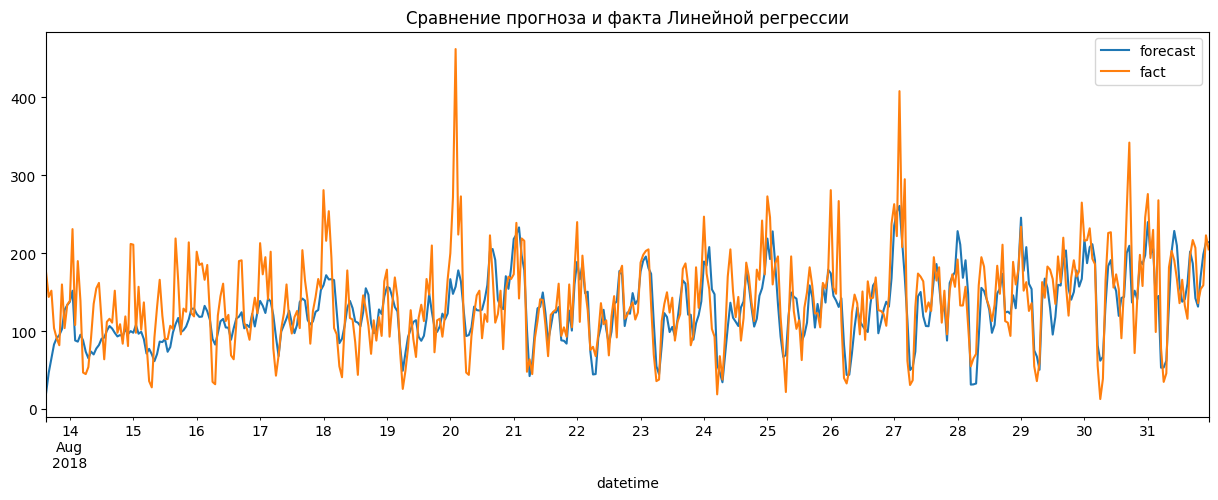

In [62]:
df_results.plot(figsize=(15,5), legend=True, title='Сравнение прогноза и факта Линейной регрессии');

Модель неплохо предсказывает динамику данных, но не справляется со выбросами.  
В некотором роде модель "стесняется" предсказывать очень большие значения.

## Общие выводы по проекту

1) Лучшие результаты по точности и скорости показала Линейная регрессия.   
Можно использовать эту модель в продакшн. 
   - Линейная регрессия единственная достигла требуемый заказчиком уровень точности.
   - Модель неплохо предсказывает динамику данных, но не справляется с большими всплесками.
   - В проекте критически важно не переобучить модель. Так, "родственная" Elastic Net с регуляризаций плохо справляется с тестовыми данными, 
      хотя точнее всех работает на кросс-валидации.  

2) Проект работает с нестационарными данными, т.к. имеются: 
   - Возрастающий тренд, причём с ускорением темпов в ок. середины рассматриваемого периода.
   - Сезонность как внутри суток, так и недельная.
   - Заметное количеством выбросов до 6 раз превышающих медианное значение.  

3) Данных мало (6 мес.). Этого может быть не достаточно для раскрытия потенциала рассмотренных моделей, а так же использования нейросетей.  
   Это подтверждается тем, что при тестировании результаты у рассмотренных моделей до 2,5 раза хуже чем на валидации.  

4) Модели общего назначения сложнее в использовании, чем специализированная Prophet:
   - Они требуют генерации отдельного, зависящего от типа модели набора признаков. Это потенциально может повлиять на надёжность решения.
   - Prophet автоматически генерирует нужный набор признаков + имеет хорошо интерпретируемые гиперпараметры.

**Возможные пути улучшения решения**

1) Запросить у заказчика данные за более длительный период (2-5 лет) и обучить и протестировать на нём модели
2) Изучить возможности применения в проекте:
   - Стекинга моделей, например использования сочетания Prophet + Light GBM
   - Предобученных и собственных нейросетей
   - Приведения данных к стационарному виду и использования специализированных моделей семейства ARIMA
   - Стандартизированных синтетических признаков, например, с помощью библиотеки Tsfresh
